<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB4.1_Deep_Learning_for_Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep portfolio optimisation
---
This notebook gives an example of portfolio optimisation using deep learning. Under an adapted trading strategy $\phi=(\phi_n)_{n=0,1,...,N}$, the portfolio value process under zero interest rate assumption is given by $$X_{n+1}-X_n=\phi_n(S_{n+1}-S_n)$$ and in turn $$X_N=x_0+\sum_{n=0}^{N-1}\phi_n (S_{n+1}-S_n)$$ where $x_0$ is initial capital available to the trader. The goal of the problem is to use neural network to solve the portfolio optimisation problem $$\sup_{\phi}\mathbb{E}\left[U(X_N)\right].$$

This notebook focuses on an example when $U$ is the exponential utility function and the stock price process $S$ is given by a discrete version of the geometric Brownian motion.

Import several usual libraries.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as si

np.random.seed(12345) # fix the random seed

# Generation of random stock price paths

Our stock price process $S=(S_n)_{n=0,1,...,N}$ is given by the value of a geometric Brownian motion sampled at some evenly spaced time intervals over a time horizon of $T$. In particular, $$S_n=s_0\exp\left(\left(\mu-\frac{\sigma^2}{2}\right)t_n+\sigma B_{t_n}\right)$$ where $t_n:=n\Delta t$ with $\Delta t:=T/N$ for $n=0,1,...,N$.

A Brownian motion path can be simualted via $$B_{t_n}=\sum_{i=1}^n \epsilon_i \sqrt{\Delta t}$$ where $\epsilon_i\stackrel{\text{i.i.d.}}{\sim} N(0,1)$.

Therefore, an equivalent way to write the process $S$ is
\begin{align}
S_n&=s_0\exp\left(\left(\mu-\frac{\sigma^2}{2}\right)t_n+\sigma B_{t_n}\right)\\
&=s_0\exp\left(\left(\mu-\frac{\sigma^2}{2}\right)n\Delta t+\sigma \sum_{i=1}^n \epsilon_i \sqrt{\Delta t}\right)\\
&=s_0\exp\left(\sum_{i=1}^n\left[\left(\mu-\frac{\sigma^2}{2}\right)\Delta t+\sigma \epsilon_i \sqrt{\Delta t}\right]\right)\\
&=s_0 \exp\left(\sum_{i=1}^n Z_i\right)
\end{align}
where $Z_i\stackrel{\text{i.i.d.}}{\sim} N\left(\left(\mu-\frac{\sigma^2}{2}\right)\Delta t,\sigma^2 \Delta t\right)$. Hence we can simulate the $Z_i$'s and then construct $S_n$ accordingly.

In [ ]:
mu, sigma, T = 0.15, 0.5, 1
s0 = 1

N = 250       # number of trading dates over the time horizon
M = 100000    # number of simulated paths

dt = T / N

# Simulate iid normal random variable with the mean (mu-0.5sigma^2)dt and variance sigma^2 dt.
# Store the values in a M by N matrix
NormalRV = np.random.normal((mu - 0.5 * sigma **2) * dt, sigma * np.sqrt(dt), (M, N))

# Add an extra column of zero as the first column of the matrix NormalRV (for storing the initial stock price s_0)
NormalRV = np.concatenate((np.zeros((M, 1)), NormalRV), axis=1)

# Return a matrix of simulated stoc price paths by invoking the formula s_n=s_0* \exp(\sum_i^n Z_i)
S = s0 * np.exp(np.cumsum(NormalRV,axis=1))

Let's look at a few simulated paths where we plot $S_n$ against $t_n$.

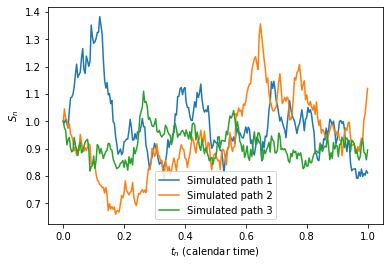

In [ ]:
t = np.linspace(0,T,N+1)

# Just plot 3 paths
for i in range(3):
    plt.plot(t,S[i,:], label="Simulated path "+str(i+1))
plt.xlabel(r"$t_n$ (calendar time)")
plt.ylabel(r"$S_n$")
plt.legend()

# Specification of the neural network

We assume that the hedging strategy only depends on the current time and the current stock price, i.e. $\phi_n=f(n,S_n)$ for some function $f(n,S)$. In contrast to the lecture notes, we will consider $\phi_n=f(t_n,S_n)$ such that it is a function of the calendar time $t_n$ rather than an arbitrary time index $n$. This will allow us to interpret the optimal strategy a bit easier.

We are going to approximate $f$ by a feedforward neural network (FNN). In this example, we will consider a FNN with 3 hidden layers where each of them carries $100$ neurons. The activation functions are relu except that the one at the final layer is an identity function.

An important consideration of our implementation is that we view the information from each simulated path as one single data point, where each path is providing us $2N$ feature values (time and current stock price at $N$ time points). The model should then output the corresponding trading position at each time point, i.e. $$f(t_0,S_0),f(t_1,S_1),...,f(t_{N-1},S_{N-1})$$

We need to structure our neural network such that it accepts an input with shape $(N,2)$ and output a vector with $N$ elements. This can be achieved as follows.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, input_shape=(N,2),activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250, 100)          300       
                                                                 
 dense_1 (Dense)             (None, 250, 100)          10100     
                                                                 
 dense_2 (Dense)             (None, 250, 100)          10100     
                                                                 
 dense_3 (Dense)             (None, 250, 1)            101       
                                                                 
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


# Defining the loss function

Our underlying problem is a portfolio optimisation with exponential utility function $U(x)=-\exp(-\gamma x)$. Hence we will define our loss function as $$\ell(\boldsymbol{y},\boldsymbol{\hat{y}})=-U(x_0+\boldsymbol{y}\cdot \boldsymbol{\hat{y}})=\exp\left(-\gamma(x_0+\boldsymbol{y}\cdot \boldsymbol{\hat{y}})\right)$$ and when training the model we are going to pass the $m^{th}$ actual label as $\boldsymbol{y}^m=(S^m_1-s_0, S^m_2-S^m_1,...,S^m_{N}-S^m_{N-1})$.

If we need to use any standard numpy operations (e.g. sum, exp, etc...) within our custom loss function definition, we have to call such functions via the "keras backend" library since numpy functions in general are incompatible with tensor objects. For most common math operations, there should be an equivalent function provided by keras backend. Visit this page to see the list of backend functions: https://keras.rstudio.com/articles/backend.html.

In [ ]:
import tensorflow.keras.backend as kb

def ExpUtilityLoss(y_true, y_pred):
    gamma = 1 # risk aversion parameter
    x0 = 0    # initial wealth
    return kb.exp(-gamma * (x0 + kb.sum(y_pred * y_true, axis=-1)))

# Preparing the training data

The training feature data "xtrain" needs to be a 3D tensor in form of xtrain[m, n, j]. The first index $m\in\{0,1,...,M-1\}$ denotes which data point (simulated path) we are referring to, the second index $n\in\{0,1,...,N-1\}$ is the time index, and the final index $j\in\{0,1\}$ determines whether we refer to the time or the current stock price as the feature. Mathematically, we construct the feature data as
\begin{align}
\text{xtrain}[m,n,j]=
\begin{cases}
t_n=n\Delta t,& j=0\\
S^{m+1}_n,& j=1
\end{cases}
\end{align}

For the label data, it is defined as
	\begin{align*}
	\text{ytrain}=
	\begin{bmatrix}
	S^1_1-S^1_0 & S^1_2-S^1_1 & \cdots & S^1_{N}-S^1_{N-1}\\
	S^2_1-S^2_0 & S^2_2-S^2_1 & \cdots & S^2_{N}-S^2_{N-1}\\
	\vdots & \vdots & \ddots & \vdots\\
	S^M_1-S^M_0 & S^M_2-S^M_1 & \cdots & S^M_{N}-S^M_{N-1}\\
	\end{bmatrix}.
	\end{align*}

In [ ]:
xtrain = np.stack([np.tile(t[0:N], (M, 1)), S[:,0:N]], axis=-1)
ytrain = np.diff(S, axis=1)

print("Shape of xtrain: ", xtrain.shape)
print("Shape of ytrain: ", ytrain.shape)

Shape of xtrain:  (100000, 250, 2)
Shape of ytrain:  (100000, 250)


# Train the model

Now we can train the model which is the easiest part once all the data structures have been handled carefully.

In [ ]:
num_epochs = 10

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ExpUtilityLoss)
r = model.fit(xtrain, ytrain, batch_size=128, epochs=num_epochs)

Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.9595
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 0.9572
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9571
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9570
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9570
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9569
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9570
Epoch 8/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9570
Epoch 9/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9569
Epoch 10/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9568


Plot the training losses over each epoch.

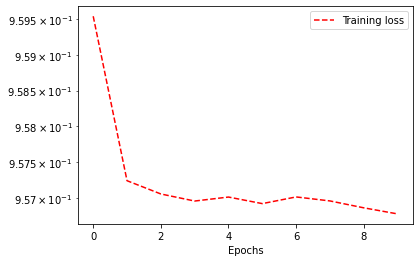

In [ ]:
train_loss = r.history['loss']

ep = range(num_epochs)
plt.plot(ep, train_loss, 'r--', label="Training loss")
plt.xlabel('Epochs')
plt.yscale("log")
plt.legend()

# Properties of the optimal hedging strategy

With the trained neural network, we can study the optimal asset holding $\phi(t,S)$ as a function of current time and stock price. In what follows, we will plot the function of $\phi(t,S)$ against $S$ for different fixed t.

The difficult bit of this part is that we need structure the input feature data as a matrix with shape $(N,2)$. We are going to supply an input feature data in form of
\begin{align}
\text{xinput}=
\begin{bmatrix}
\bar{t} & s_0\\
\bar{t} & s_1 \\
\bar{t} & s_2 \\
\vdots & \vdots \\
\bar{t} & s_{N-1}
\end{bmatrix}
\end{align}
where $\bar{t}$ is a fixed time point. Then the output of the neural network is a vector with values $\{\phi(\bar{t},s_{n})\}_{n=0,...,N-1}$.

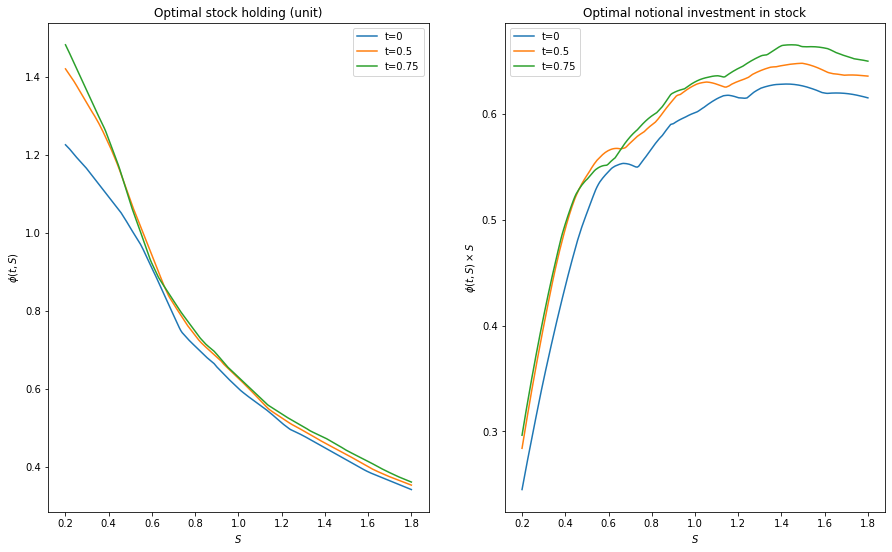

In [ ]:
list_t = [0, 0.5, 0.75]
s_range = np.linspace(0.2, 1.8, N) # range of S for plotting of \phi(t,s)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))

for fix_t in list_t:
    X = np.stack([np.ones((1,N))*fix_t, np.reshape(s_range, (1,N))], axis=-1)
    phi = model.predict(X)
    phi = phi.flatten()
    ax[0].plot(s_range,phi, label="t="+str(fix_t))
    ax[1].plot(s_range,phi*s_range, label="t="+str(fix_t))
ax[0].set_xlabel(r'$S$')
ax[1].set_xlabel(r'$S$')
ax[0].set_ylabel(r'$\phi(t,S)$')
ax[1].set_ylabel(r'$\phi(t,S)\times S$')
ax[0].set_title(r'Optimal stock holding (unit)')
ax[1].set_title(r'Optimal notional investment in stock')
ax[0].legend()
ax[1].legend()